In [1]:
pip install clingo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Reshape, Activation
import time
import numpy as np
import random
import clingo

import clingo

def sudoku_to_asp(sudoku_board):
    n = len(sudoku_board)
    control = clingo.Control()

    asp_program = ""
    subgrid_size = int(n**0.5)

    # Define cell values
    for i in range(n):
        for j in range(n):
            cell_value = sudoku_board[i][j]
            if cell_value != 0:
                asp_program += f"cell({i+1},{j+1},{cell_value}).\n"

    # Sudoku rules for rows, columns, and subgrids
    asp_program += """
        { cell(Row,Col,Val) : Val=1..9 } = 1 :- Row=1..9, Col=1..9.
        :- cell(Row,Col1,Val), cell(Row,Col2,Val), Col1 != Col2.
        :- cell(Row1,Col,Val), cell(Row2,Col,Val), Row1 != Row2.
        :- cell(Row1,Col1,Val), cell(Row2,Col2,Val), Row1 != Row2, Col1 != Col2, (Row1-1)/3 = (Row2-1)/3, (Col1-1)/3 = (Col2-1)/3.
    """

    control.add("base", [], asp_program)
    control.ground([("base", [])])

    solutions = []
    for sol in control.solve(yield_=True):
        solution_grid = np.zeros((n, n), dtype=int)
        for symbol in sol.symbols(shown=True):
            if symbol.name == "cell":
                row, col, value = symbol.arguments
                solution_grid[row.number - 1][col.number - 1] = value.number
        solutions.append(solution_grid)

    return solutions




def create_random_mask(num_empty):
    mask = np.ones((9, 9), dtype=int)
    count = 0
    while count < num_empty:
        i, j = random.randint(0, 8), random.randint(0, 8)
        if mask[i][j] != 0:
            mask[i][j] = 0
            count += 1
    return mask

def is_valid(grid, row, col, num):
    # Check if the number is already used in the row, column, or 3x3 box
    box_row = row - row % 3
    box_col = col - col % 3
    if any(grid[row, :] == num) or any(grid[:, col] == num) or any(grid[box_row:box_row+3, box_col:box_col+3].flatten() == num):
        return False
    return True

def solve_sudoku(grid):
    empty = np.where(grid == 0)
    if len(empty[0]) == 0:  # No more empty cells
        return True

    row, col = empty[0][0], empty[1][0]

    for num in range(1, 10):
        if is_valid(grid, row, col, num):
            grid[row, col] = num
            if solve_sudoku(grid):
                return True
            grid[row, col] = 0  # Backtrack

    return False

def generate_sudoku_puzzle(difficulty=90):
    puzzle = np.zeros((9, 9), dtype=int)
    solve_sudoku(puzzle)  # Fill the grid with a valid solution
    mask = create_random_mask(difficulty)
    return puzzle * mask

def generate_masked_and_full_data(num_puzzles=500, mask_rate=0.9):
    """Generates puzzles with partially masked solutions and full solutions."""
    puzzles = []
    masked_solutions = []
    full_solutions = []
    for _ in range(num_puzzles):
        puzzle = generate_sudoku_puzzle(10)
        full_solution = sudoku_to_asp(puzzle)[0]  # Assuming each puzzle has a unique solution
        masked_solution = mask_solution(full_solution, mask_rate)
        puzzles.append(puzzle)
        masked_solutions.append(masked_solution)
        full_solutions.append(full_solution)
    return np.array(puzzles), np.array(masked_solutions), np.array(full_solutions)

def generate_sudoku_data(num_puzzles=500):
    puzzles = []
    solutions = []
    for _ in range(num_puzzles):
        puzzle = generate_sudoku_puzzle(90)  # Generate puzzle
        solutions_for_puzzle = sudoku_to_asp(puzzle)  # Solve puzzle with Clingo
        # Since sudoku_to_asp may return multiple solutions, we'll keep all of them
        puzzles.append(puzzle)
        solutions.extend(solutions_for_puzzle)
    return np.array(puzzles), np.array(solutions)



def prepare_data(puzzles, solutions):
    X = puzzles.reshape((-1, 81)).astype(float) / 9  # Normalized input

    # Adjust solutions to be 0-indexed and then one-hot encode
    y_adjusted = solutions - 1  # Subtract 1 to make the range 0-8
    y_encoded = tf.keras.utils.to_categorical(y_adjusted, num_classes=9)
    y = y_encoded.reshape((-1, 9, 9, 9))  # Reshape to match the model output

    return X, y


def unique_numbers_loss(y_pred, y_true):
    loss = 0

    # Iterate over each row, column, and subgrid
    for i in range(9):
        # Rows
        row_pred = y_pred[:, i, :, :]
        row_true = y_true[:, i, :, :]
        row_loss = tf.reduce_sum(tf.abs(tf.reduce_sum(row_pred, axis=-1) - tf.reduce_sum(row_true, axis=-1)))

        # Columns
        col_pred = y_pred[:, :, i, :]
        col_true = y_true[:, :, i, :]
        col_loss = tf.reduce_sum(tf.abs(tf.reduce_sum(col_pred, axis=-1) - tf.reduce_sum(col_true, axis=-1)))

        loss += row_loss + col_loss

        # Subgrids
        for j in range(9):
            subgrid_pred = y_pred[:, 3 * (i // 3):3 * (i // 3) + 3, 3 * (j // 3):3 * (j // 3) + 3, :]
            subgrid_true = y_true[:, 3 * (i // 3):3 * (i // 3) + 3, 3 * (j // 3):3 * (j // 3) + 3, :]
            subgrid_loss = tf.reduce_sum(tf.abs(tf.reduce_sum(subgrid_pred, axis=(-1, -2)) - tf.reduce_sum(subgrid_true, axis=(-1, -2))))

            loss += subgrid_loss

    return loss


def sudoku_constraints_loss(y_pred, full_y_true):
    constraints_loss = 0

    # Identify cells that were empty in the original puzzle
    is_empty = tf.cast(tf.reduce_sum(full_y_true, axis=-1) == 0, tf.float32)

    # Calculate constraints for each number (1 through 9)
    for num in range(9):
        num_present = y_pred[:, :, :, num]

        # Row and column constraints for non-predefined cells
        for i in range(9):
            row_constraint = tf.reduce_sum(num_present[:, i, :] * is_empty[:, i, :], axis=1)
            col_constraint = tf.reduce_sum(num_present[:, :, i] * is_empty[:, :, i], axis=1)
            constraints_loss += tf.reduce_sum(tf.square(row_constraint - 1)) + tf.reduce_sum(tf.square(col_constraint - 1))

        # Subgrid constraints for non-predefined cells
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                subgrid_constraint = tf.reduce_sum(num_present[:, i:i+3, j:j+3] * is_empty[:, i:i+3, j:j+3], axis=[1, 2])
                constraints_loss += tf.reduce_sum(tf.square(subgrid_constraint - 1))

    return constraints_loss

def mse_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)


# Loss combination functions
def mse_only(y_true, y_pred, full_y_true):
    return mse_loss(y_true, y_pred)

def uniqueness_loss(y_pred, full_y_true):
    return unique_numbers_loss(y_pred, full_y_true)

def mse_and_uniqueness(y_true, y_pred, full_y_true):
    return mse_loss(y_true, y_pred) + uniqueness_loss(y_pred, full_y_true)

def mse_and_constraints(y_true, y_pred, full_y_true):
    return mse_loss(y_true, y_pred) + constraints_loss(y_pred, full_y_true)

def uniqueness_and_constraints(y_true, y_pred, full_y_true):
    return uniqueness_loss(y_pred, full_y_true) + constraints_loss(y_pred, full_y_true)

def all_losses_combined(y_true, y_pred, full_y_true):
    return mse_loss(y_true, y_pred) + uniqueness_loss(y_pred, full_y_true) + constraints_loss(y_pred, full_y_true)

def constraints_loss(y_true, y_pred):
    constraints = sudoku_constraints_loss(y_true, y_pred)
    return constraints

def mask_solution(solution, mask_rate=0.5):
    """Randomly masks a portion of the solution."""
    masked_solution = solution.copy()
    num_cells = solution.size
    num_masked = int(mask_rate * num_cells)
    mask_indices = np.random.choice(num_cells, num_masked, replace=False)
    np.put(masked_solution, mask_indices, 0)  # Replace selected cells with 0
    return masked_solution

def custom_loss_function(masked_y_true, y_pred, full_y_true=None):
    if full_y_true is None:
        # During evaluation, only consider the masked_y_true and y_pred
        return tf.keras.losses.mean_squared_error(masked_y_true, y_pred)
    else:
        mse_loss = tf.keras.losses.mean_squared_error(masked_y_true, y_pred)
        uniqueness_loss_val = unique_numbers_loss(y_pred)  # Not using full_y_true
        constraints_loss_val = sudoku_constraints_loss(y_pred, full_y_true)  # Use full solution
        total_loss = mse_loss + uniqueness_loss_val + constraints_loss_val
        return tf.maximum(total_loss, 0)  # Ensure non-negative loss

# Custom loss function wrapper
def create_loss_function(loss_fn):
    def custom_loss(y_true, y_pred, full_y):
        return loss_fn(y_true, y_pred, full_y)  # Pass all three arguments to the loss function
    return custom_loss

def create_model(loss_function):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(81,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9 * 9 * 9))
    model.add(Reshape((9, 9, 9)))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss=loss_function)
    return model

def calculate_accuracy(predicted_solutions, actual_solutions):
    correct_predictions = np.sum(predicted_solutions == actual_solutions)
    total_predictions = np.product(actual_solutions.shape)
    accuracy = correct_predictions / total_predictions
    return accuracy



In [3]:
from sklearn.model_selection import KFold
import numpy as np

# Parameters
num_folds = 3
batch_size = 4
epochs = 10

# Generate data
puzzles, masked_solutions, full_solutions = generate_masked_and_full_data(100, 0.3)
X, masked_y = prepare_data(puzzles, masked_solutions)
_, full_y = prepare_data(puzzles, full_solutions)

# Define k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

# Loss combinations
loss_combinations = {
    "MSE Only": create_loss_function(mse_only),
    "MSE + Uniqueness": create_loss_function(mse_and_uniqueness),
    "MSE + Constraints": create_loss_function(mse_and_constraints),
    "Uniqueness + Constraints": create_loss_function(uniqueness_and_constraints),
    "All Combined": create_loss_function(all_losses_combined)
}

# Store results
all_fold_results = []

# Loop over each fold
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Running fold {fold + 1}/{num_folds}")

    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    masked_y_train, masked_y_val = masked_y[train_index], masked_y[val_index]
    full_y_train, full_y_val = full_y[train_index], full_y[val_index]

    # Results for each loss combination in this fold
    fold_results = []

    for name, loss_function in loss_combinations.items():
        model = create_model(loss_function)
        optimizer = tf.keras.optimizers.Adam()

        # Training loop
        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i + batch_size]
                masked_y_batch = masked_y_train[i:i + batch_size]
                full_y_batch = full_y_train[i:i + batch_size]

                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = loss_function(masked_y_batch, predictions, full_y_batch)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Evaluation
        predicted_solutions = []
        actual_solutions = []
        for i in range(0, len(X_val), batch_size):
            X_batch_val = X_val[i:i + batch_size]
            y_batch_val = full_y_val[i:i + batch_size]
            batch_predictions = model(X_batch_val)
            predicted_solutions.extend(np.argmax(batch_predictions, axis=-1) + 1)
            actual_solutions.extend(np.argmax(y_batch_val, axis=-1) + 1)

        predicted_solutions = np.array(predicted_solutions)
        actual_solutions = np.array(actual_solutions)
        accuracy = calculate_accuracy(predicted_solutions, actual_solutions)
        fold_results.append((name, accuracy))

    all_fold_results.append(fold_results)

# Process overall results
# You can calculate mean and standard deviation of accuracy for each loss combination across folds


Running fold 1/3
Running fold 2/3
Running fold 3/3


In [ ]:

import numpy as np

# Initialize a dictionary to hold all accuracies for each loss combination
loss_combination_accuracies = {name: [] for name in loss_combinations.keys()}

# Collect all accuracies for each loss combination
for fold_results in all_fold_results:
    for name, accuracy in fold_results:
        loss_combination_accuracies[name].append(accuracy)

# Calculate mean and standard deviation for each loss combination
mean_std_results = {}
for name, accuracies in loss_combination_accuracies.items():
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_std_results[name] = (mean_accuracy, std_accuracy)

# Print the results
for name, (mean_accuracy, std_accuracy) in mean_std_results.items():
    print(f"Loss Combination: {name}, Mean Accuracy: {mean_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")


Loss Combination: MSE Only, Mean Accuracy: 0.11, Standard Deviation: 0.00
Loss Combination: MSE + Uniqueness, Mean Accuracy: 0.11, Standard Deviation: 0.00
Loss Combination: MSE + Constraints, Mean Accuracy: 0.11, Standard Deviation: 0.00
Loss Combination: Uniqueness + Constraints, Mean Accuracy: 0.10, Standard Deviation: 0.04
Loss Combination: All Combined, Mean Accuracy: 0.11, Standard Deviation: 0.00


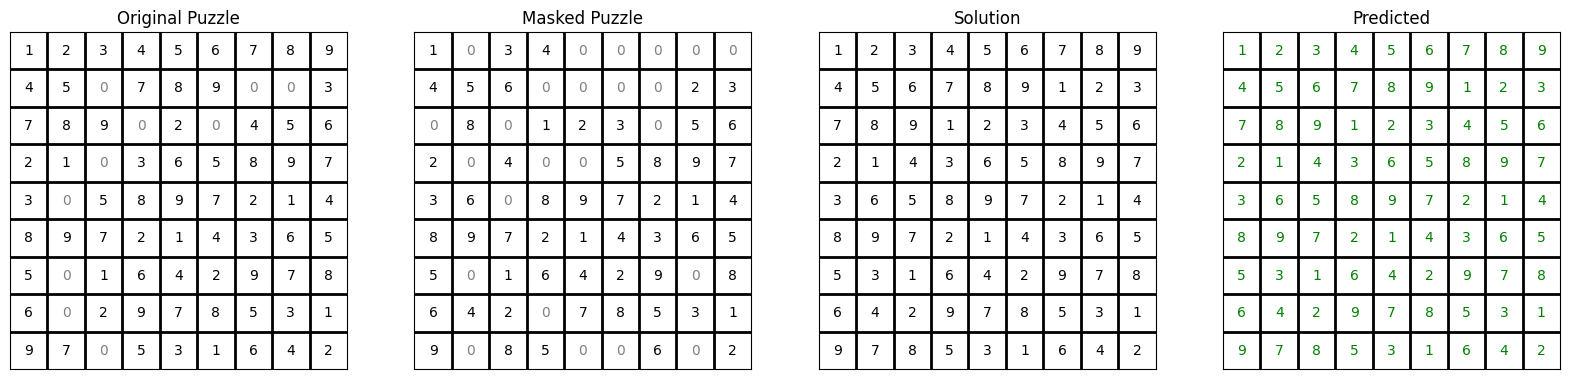

In [7]:
import matplotlib.pyplot as plt

def plot_sudoku_puzzles(puzzle, masked, solution, predicted):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    puzzles = [puzzle, masked, solution, predicted]
    titles = ['Original Puzzle', 'Masked Puzzle', 'Solution', 'Predicted']

    for ax, grid, title in zip(axes, puzzles, titles):
        ax.matshow(np.zeros((9, 9)), cmap='Greys', alpha=0.3)
        for (i, j), z in np.ndenumerate(grid):
            if title == 'Predicted':
                color = 'green' if z == solution[i, j] and z != 0 else 'red'
                ax.text(j, i, f'{z}', ha='center', va='center', color=color if z != 0 else 'gray')
            else:
                ax.text(j, i, f'{z}', ha='center', va='center', color='black' if z != 0 else 'gray')
        ax.set_title(title)
        ax.set_xticks(np.arange(8) + 0.5, minor=True)
        ax.set_yticks(np.arange(8) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.show()

# Example: Selecting the first puzzle
puzzle_index = 0
original_puzzle = puzzles[puzzle_index]
masked_puzzle = masked_solutions[puzzle_index]
actual_solution = full_solutions[puzzle_index]
predicted_solution = predicted_solutions[puzzle_index]

plot_sudoku_puzzles(original_puzzle, masked_puzzle, actual_solution, predicted_solution)



1/1 [==============================] - 0s 34ms/step


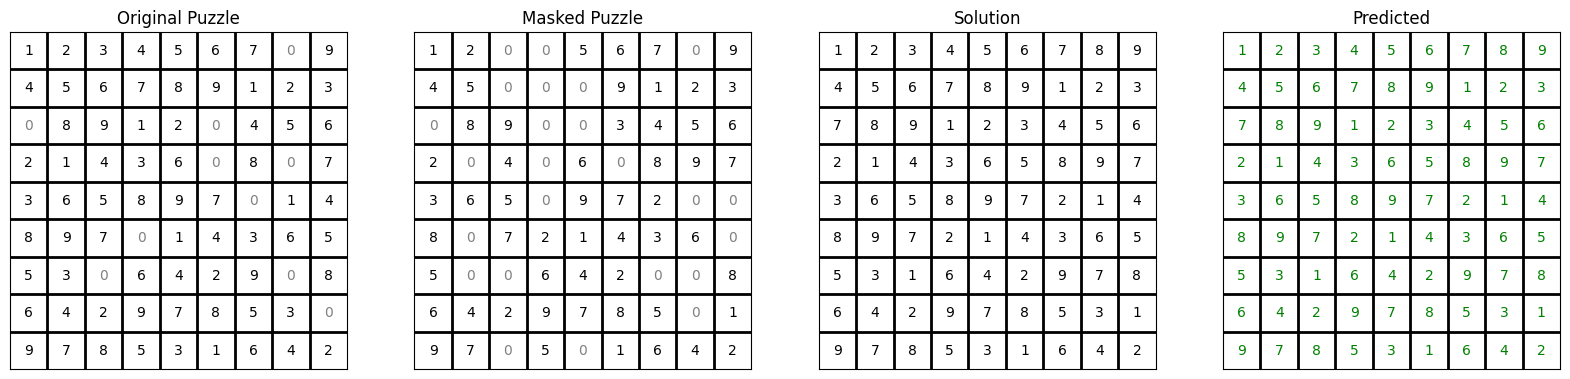

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sudoku_puzzles(puzzle, masked, solution, predicted):
    assert puzzle.shape == (9, 9), "Puzzle shape is not 9x9"
    assert masked.shape == (9, 9), "Masked puzzle shape is not 9x9"
    assert solution.shape == (9, 9), "Solution shape is not 9x9"
    assert predicted.shape == (9, 9), "Predicted puzzle shape is not 9x9"

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    puzzles = [puzzle, masked, solution, predicted]
    titles = ['Original Puzzle', 'Masked Puzzle', 'Solution', 'Predicted']

    for ax, grid, title in zip(axes, puzzles, titles):
        ax.matshow(np.zeros((9, 9)), cmap='Greys', alpha=0.3)
        for (i, j), z in np.ndenumerate(grid):
            if title == 'Predicted':
                color = 'green' if z == solution[i, j] and z != 0 else 'red'
                ax.text(j, i, f'{z}', ha='center', va='center', color=color if z != 0 else 'gray')
            else:
                ax.text(j, i, f'{z}', ha='center', va='center', color='black' if z != 0 else 'gray')
        ax.set_title(title)
        ax.set_xticks(np.arange(8) + 0.5, minor=True)
        ax.set_yticks(np.arange(8) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.show()

# Rest of your code to generate and prepare puzzles
# ...

# Make sure to reshape the puzzles correctly
original_puzzle = puzzle[0].reshape((9, 9))
masked_puzzle = masked_solution[0].reshape((9, 9))
actual_solution = full_solution[0].reshape((9, 9))
predicted_solution = model.predict(X)
predicted_solution = np.argmax(predicted_solution, axis=-1) + 1  # Convert from one-hot encoding to numerical values
predicted_solution = predicted_solution.reshape((9, 9))  # Reshape to 9x9 grid

plot_sudoku_puzzles(original_puzzle, masked_puzzle, actual_solution, predicted_solution)
